# LAB 5: NN4: Solve the classification task
Implement the softmax function for the output layer of the neural network. Check the speed and efficiency in the variant when the network uses the softmax function on the last layer and when the usual activation function is used. Softmax also requires appropriate changes in the learning algorithm, taking into account the derivative of the function.

Perform experiments on sets (in parentheses the required F-measure value for 2 points):
* rings3-regular (F-measure: 0.75),
* easy (F-measure: 0.99),
* xor3 (F-measure: 0.97).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, log_loss
import copy
from scipy.special import expit

In [2]:
def linear(x):
    return x

def softmax(x):
    e_x = np.exp(x.T - np.max(x, axis=1).T).T
    return (e_x.T / e_x.sum(axis=1).T).T
    
def sigmoid(x):
    return expit(x)

def der_sigm(x):
    return expit(x)*(1 - expit(x))

In [3]:
def feedforward(x, weights, biases, activation_fun_out='linear'):
    activations = [x]
    zs = []
    for j in range(len(weights)-1):
        z = np.dot(activations[-1], weights[j]) + biases[j]
        zs.append(z)
        activation = sigmoid(z)   
        activations.append(activation)

    z = np.dot(activations[-1], weights[-1]) + biases[-1]
    zs.append(z)
    if activation_fun_out == 'softmax':
        activation = softmax(z)
    else:
        activation = linear(z)
    activations.append(activation)
    return activations, zs

In [4]:
def backpropagation(y, weights, biases, activations, zs, layers, activation_fun_out=False):
    deltas = [None] * len(weights)

    if activation_fun_out == 'softmax':
        result = []
        for e_x, e_y in zip(activations[-1], y):
            error = e_y - e_x
            x = e_x.reshape(e_x.shape[0], )
            si_sj = - x * x.reshape(layers[-1], 1)
            s_der = np.diag(x) + si_sj
            result.append(s_der @ error)
        result = np.array(result)
        deltas[-1] = copy.deepcopy(result)
    else:
        deltas[-1] = y - activations[-1]

    for i in reversed(range(len(deltas) - 1)):
        deltas[i] = ((weights[i + 1] @ deltas[i + 1].T) * der_sigm(zs[i]).T).T

    y_size = y.shape[0]
    biases_prime = [None] * len(deltas)
    weights_prime = [None] * len(deltas)

    for i, d in enumerate(deltas):
        weights_prime[i] = (d.T @ activations[i]).T / y_size
        biases_prime[i] = (d.T @ np.ones((y_size, 1))).T / y_size

    return weights_prime, biases_prime

In [5]:
def generate_weights_and_biases(layers, init_method):
    weights = []
    biases = []
    if init_method == 'uniform':
        for i in range(1, len(layers)):
            np.random.seed(123)
            weights.append(np.random.uniform(low=0.0, high=1.0, size=(layers[i-1], layers[i])))
            biases.append(np.zeros((1, layers[i])))
    elif init_method == 'Xavier':
        for i in range(1, len(layers)):
            np.random.seed(123)
            weights.append(np.random.randn(layers[i-1], layers[i]) * np.sqrt(1/layers[i-1]))
            biases.append(np.random.randn(1, layers[i])*np.sqrt(1/(layers[i-1])))
    elif init_method == 'He':
        for i in range(1, len(layers)):
            np.random.seed(777)
            weights.append(np.random.randn(layers[i-1], layers[i]) * np.sqrt(2/layers[i-1]))
            biases.append(np.random.randn(1, layers[i])*np.sqrt(2/(layers[i-1])))
                          
    return weights, biases

In [6]:
def update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime, method, lambda_moment=None, momentum_w=None, momentum_b=None, beta_rms=None, grad_sq_w=None, grad_sq_b=None):

    for i in range(len(weights)):

            if method == 'SGD':
                weights[i] += learning_rate * weights_prime[i]
                biases[i] += learning_rate * biases_prime[i]
                
            elif method == 'momentum':
                momentum_w[i] = weights_prime[i] + lambda_moment * momentum_w[i]
                weights[i] += learning_rate * momentum_w[i]
                momentum_b[i] = biases_prime[i] + lambda_moment * momentum_b[i]
                biases[i] += learning_rate * momentum_b[i]

            elif method == 'RMSProp':
                grad_sq_w[i] = beta_rms*grad_sq_w[i] + (1-beta_rms)*weights_prime[i]**2
                weights[i] += learning_rate * (weights_prime[i] / np.sqrt(grad_sq_w[i]))
                grad_sq_b[i] = beta_rms*grad_sq_b[i] + (1-beta_rms)*biases_prime[i]**2
                biases[i] += learning_rate * (biases_prime[i] / np.sqrt(grad_sq_b[i])) 
                
    return weights, biases

In [18]:
def train(x, y, x_test, data_test, batch_size, epochs, learning_rate, layers, method, is_scaled=True, lambda_moment=0.5,
          beta_rms=0.5, activation_fun_out=False):

    weights, biases = generate_weights_and_biases(layers, init_method='uniform')

    p = np.random.permutation(len(y))

    if activation_fun_out == 'softmax':
        b = np.zeros((y.size, y.max() + 1))
        b[np.arange(y.size), y.flatten()] = 1
        y = b

    x = x[p]
    y = y[p]

    momentum_w = [np.zeros(w.shape) for w in weights]
    momentum_b = [np.zeros(b.shape) for b in biases]

    grad_sq_w= [np.zeros(w.shape) for w in weights]
    grad_sq_b = [np.zeros(b.shape) for b in biases]

    losses = []
    for epoch in range(epochs):
        i = 0

        while i < len(y):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            i = i + batch_size
            activations, zs = feedforward(x_batch, weights, biases, activation_fun_out)
            weights_prime, biases_prime = backpropagation(y_batch, weights, biases, activations, zs, layers, activation_fun_out)
            weights, biases = update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime, method, lambda_moment, momentum_w, momentum_b, beta_rms, grad_sq_w, grad_sq_b)   
    
        if epoch % 10 == 0:
            activ, zki = feedforward(x_test, weights, biases, activation_fun_out='softmax')
            result = np.argmax(activ[-1], axis = 1)
            losses.append(f1_score(data_test['c'], result, average = 'macro'))

    return weights, biases, losses

## rings3-regular

In [26]:
data_train = pd.read_csv('../data/classification/rings3-regular-training.csv')
data_test = pd.read_csv('../data/classification/rings3-regular-test.csv')

##### output activation function: softmax

In [27]:
x = np.asarray(data_train.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_test = np.asarray(data_test.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)

layers=[2, 20, 3]
weights, biases, losses_softmax = train(x, y, x_test, data_test, batch_size = 32, epochs = 1000, learning_rate = 0.01, layers=layers, method='momentum', is_scaled =False, lambda_moment = 0.9, beta_rms = 0.5, activation_fun_out='softmax')
        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))

F1 na zbiorze testowym: 0.863197584000469


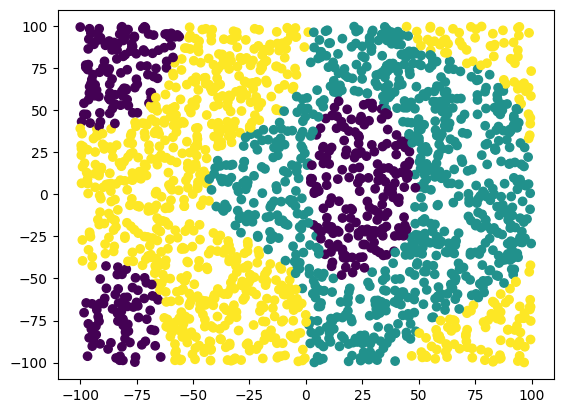

In [28]:
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

##### output activation function: linear

In [29]:
x = np.asarray(data_train.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_test = np.asarray(data_test.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)

layers=[2, 10, 2]
weights, biases, losses_linear = train(x, y, x_test, data_test, batch_size=32, epochs=1000 , learning_rate = 0.02, layers=layers, method='momentum', is_scaled =False, lambda_moment = 0.9, beta_rms = 0.5, activation_fun_out = 'linear')
        
predictions_b,z = feedforward(x_test,weights, biases)
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))

F1 na zbiorze testowym: 0.25786752404308094


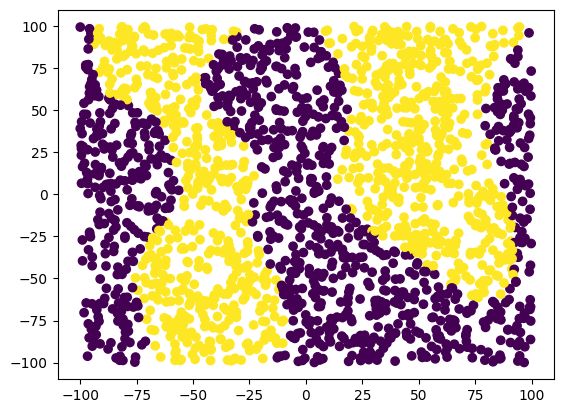

In [30]:
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

##### COMPARISON: output activation function: linear vs softmax

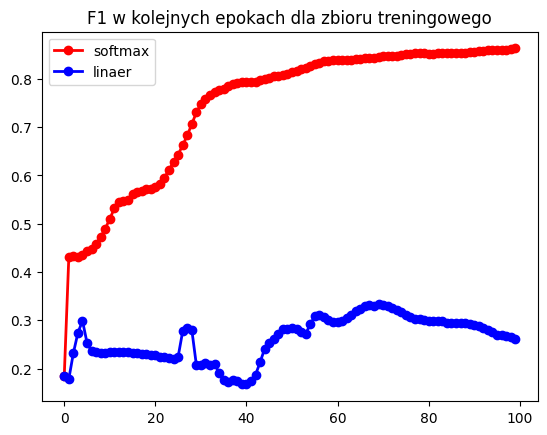

In [31]:
plt.plot(range(0, (1000//10)), losses_softmax, color='red', marker='o', linewidth=2, label='softmax')
plt.plot(range(0, (1000//10)), losses_linear, color='blue', marker='o', linewidth=2, label='linaer')
plt.title("F1 w kolejnych epokach dla zbioru treningowego")
plt.legend()
plt.show()

## easy

In [32]:
data_train = pd.read_csv('../data/classification/easy-training.csv')
data_test = pd.read_csv('../data/classification/easy-test.csv')
data_train['c'] = np.where(data_train['c'], 1, 0)
data_test['c'] = np.where(data_test['c'], 1, 0)

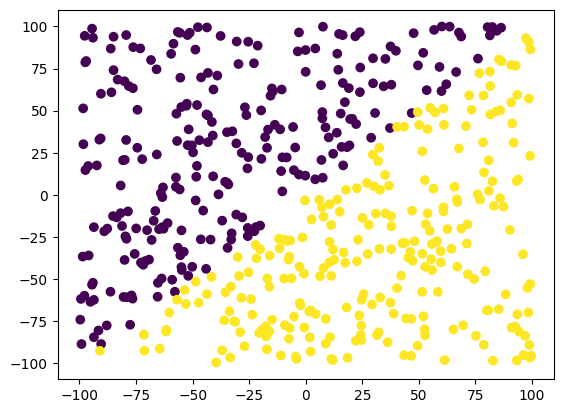

In [33]:
plt.scatter(data_train['x'], data_train['y'], c=data_train['c'])
plt.show()

##### output activation function: softmax

In [34]:
x = np.asarray(data_train.iloc[:,0:2])
x_test = np.asarray(data_test.iloc[:,0:2])
y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)

layers=[2, 10, 2]
weights, biases, losses_softmax = train(x, y, x_test, data_test, batch_size=20, epochs=1000, learning_rate = 0.001, layers=layers,  method='momentum', is_scaled =False, lambda_moment = 0.9, beta_rms = 0.5, activation_fun_out = 'softmax')
        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))

F1 na zbiorze testowym: 0.9979999279974079


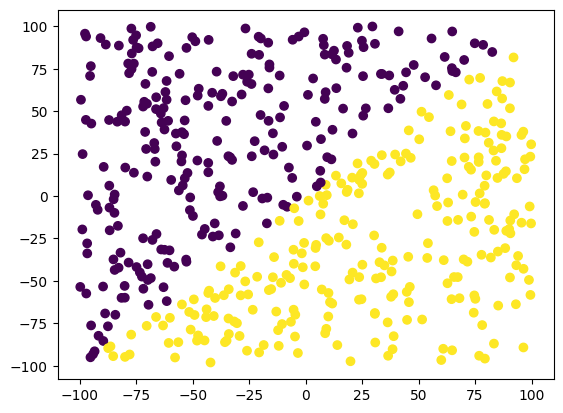

In [35]:
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

##### output activation function: linear

In [39]:
x = np.asarray(data_train.iloc[:,0:2])
x_test = np.asarray(data_test.iloc[:,0:2])

y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)

layers=[2, 200, 2]
weights, biases, losses_linear = train(x, y, x_test, data_test, batch_size=32, epochs=1000, learning_rate=0.01, layers=layers, method='momentum', is_scaled =False, lambda_moment = 0.9, beta_rms = 0.5, activation_fun_out = 'linear')
        
predictions_b,z = feedforward(x_test,weights, biases, activation_fun_out = 'linear')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))

F1 na zbiorze testowym: 0.46647138822052514


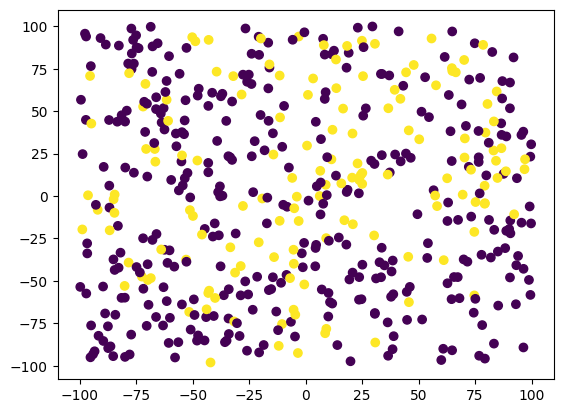

In [40]:
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

##### COMPARISON: output activation function: linear vs softmax

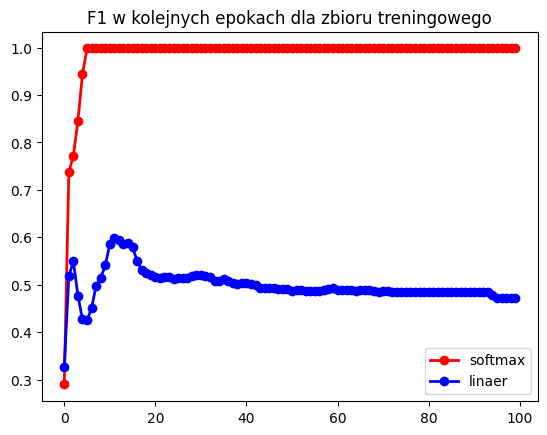

In [41]:
plt.plot(range(0, (1000//10)), losses_softmax, color='red', marker='o', linewidth=2, label='softmax')
plt.plot(range(0, (1000//10)), losses_linear, color='blue', marker='o', linewidth=2, label='linaer')
plt.title("F1 w kolejnych epokach dla zbioru treningowego")
plt.legend()
plt.show()

## xor3

In [42]:
data_train = pd.read_csv('../data/classification/xor3-training.csv')
data_test = pd.read_csv('../data/classification/xor3-test.csv')

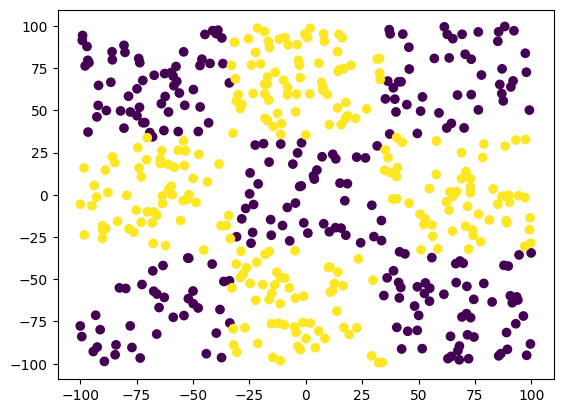

In [43]:
plt.scatter(data_train['x'], data_train['y'], c=data_train['c'])
plt.show()

##### output activation function: softmax

In [151]:
x = np.asarray(data_train.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_test = np.asarray(data_test.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)

layers=[2, 10, 10, 2]
weights, biases, losses_softmax = train(x, y, x_test, data_test, batch_size=5, epochs=30000, learning_rate=0.01, layers=layers, method='RMSProp', is_scaled=False, lambda_moment=0.9, beta_rms=0.72, activation_fun_out='softmax')
        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))

F1 na zbiorze testowym: 0.930640554875561


In [152]:
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'micro'))

F1 na zbiorze testowym: 0.932


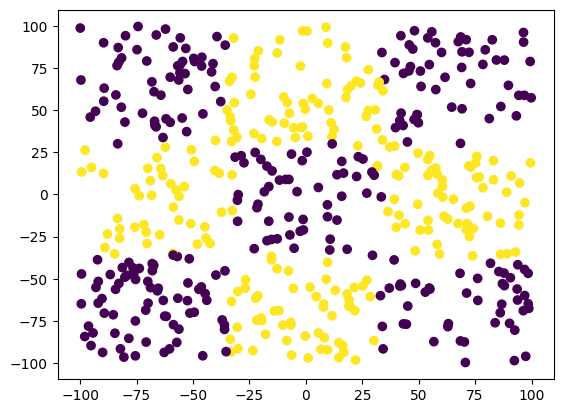

In [145]:
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

##### output activation function: linear

In [155]:
x = np.asarray(data_train.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_test = np.asarray(data_test.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)

layers=[2, 10, 10, 2]
weights, biases, losses_linear = train(x, y, x_test, data_test, batch_size=5, epochs=30000, learning_rate=0.01, layers=layers, method='RMSProp', is_scaled=False, lambda_moment=0.9, beta_rms=0.7, activation_fun_out='linear')
        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun_out='linear')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))

F1 na zbiorze testowym: 0.37027707808564225


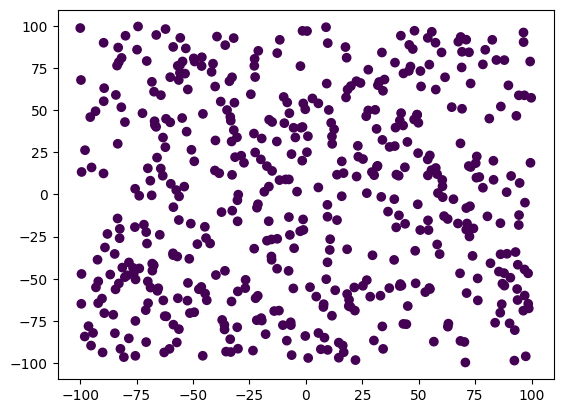

In [156]:
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

##### COMPARISON: output activation function: linear vs softmax

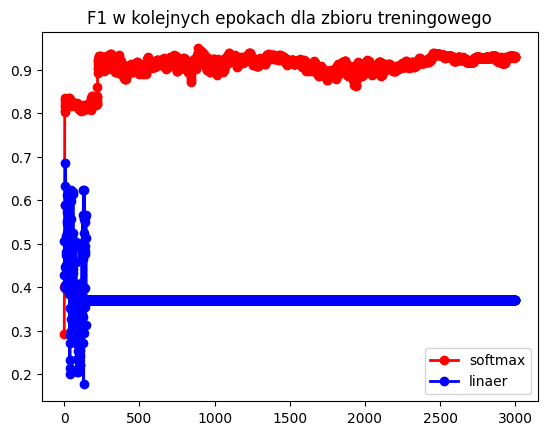

In [157]:
plt.plot(range(0, (30000//10)), losses_softmax, color='red', marker='o', linewidth=2, label='softmax')
plt.plot(range(0, (30000//10)), losses_linear, color='blue', marker='o', linewidth=2, label='linaer')
plt.title("F1 w kolejnych epokach dla zbioru treningowego")
plt.legend()
plt.show()

In [154]:
max(losses_softmax)

0.9487853944139206